    Updating git-repo `https://github.com/JuDO-dev/AirBorne.jl#dev`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


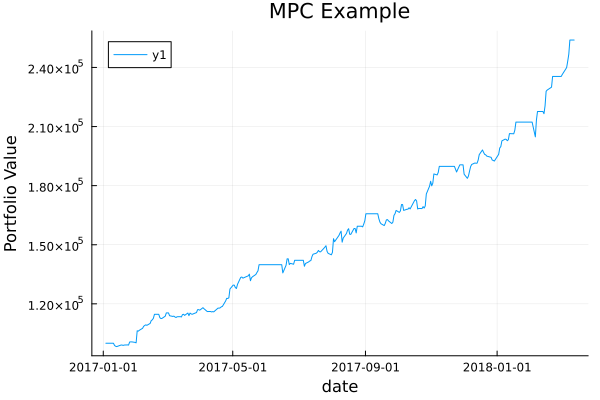

In [8]:
using Pkg;Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
Pkg.add(["Dates","Plots","DataFrames"])
using Plots, Dates 
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.Engines.DEDS: run
using AirBorne.Structures: ContextTypeA,summarizePerformance,TimeEvent
using AirBorne.ETL.AssetValuation: stockValuation, returns
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data, executeOrder_CA!
import AirBorne.Strategies.MeanVarianceMPC as mpc
# Data Generation
unix(x)=string(round(Int, datetime2unix(DateTime(x))))
data=get_interday_data(["AAPL","GOOG"], unix("2017-01-01"), unix("2022-01-01"))
sv=stockValuation(data);sv[!,"FEX/USD"].=1.0;sr=returns(sv)
evaluationEvents=[TimeEvent(t, "evnt") for t in sort(unique(data.date); rev=true)]
# Parameters
fee=Vector{Dict}([Dict("FeeName" => "SaleCommission", 
    "fixedPrice" => 0.0, "variableRate" => 0.02)])
prm=Dict("horizon" => 15, "propCost"=>0.02, "riskWeight"=>0.0)
extr=Dict("symbolOrder" => collect(unique(data.assetID)))
forecastFun(context)=mpc.predeterminedReturns(context, sr)
# MV-MPC
init!(c)=mpc.initialize!(c;currency_symbol="FEX/USD",min_data_samples=5,
    otherExtras=extr,parameters=prm)
tl!(c,d)=mpc.tradingLogic!(c, d; forecastFun=forecastFun)
# Market
single_trade_fun(c,o,d)=executeOrder_CA!(c, o, d;
        defaultFeeStructures=fee,partialExecutionAllowed=false)
my_exec_orders!(c, d)=execute_orders!(c, d; 
    propagateBalanceToPortfolio=true, executeOrder=single_trade_fun)
ed(c,d)=expose_data(c,d; historical=false)
# Simulation
mpc_context=run(data,init!,tl!,my_exec_orders!,ed;
    audit=true,max_iter=300,initialEvents=evaluationEvents)
# Analysis
ud=deepcopy(data[data.assetID .== mpc_context.extra.symbolOrder[1], :])
ud[!, "assetID"] .= "FEX/USD";ud[!, "exchangeName"] .= "FEX";ud[!, [:volume]] .= 0
ud[!, "symbol"] .= "USD";ud[!, [:close, :high, :low, :open]] .= 1.0
results=summarizePerformance(vcat(data, ud), mpc_context; includeAccounts=false)
plotd=plot(results.date, results.dollarValue, title="MPC Example", 
    label="MV-MPC", linewidth=3, xlabel="date",ylabel="Portfolio Value")

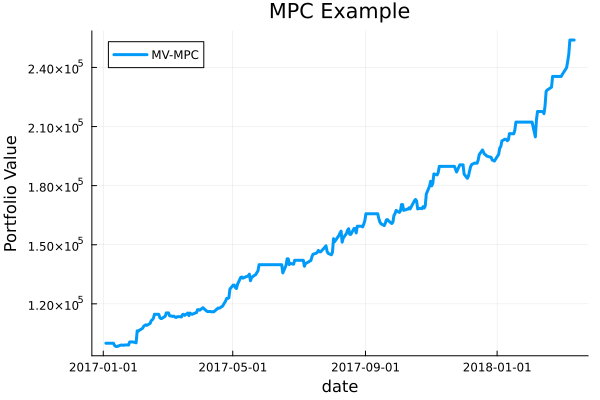

In [10]:

# using : get_interday_data
# using AirBorne.Engines.DEDS: run
# using AirBorne.Structures: ContextTypeA,summarizePerformance,TimeEvent
# using AirBorne.ETL.AssetValuation: stockValuation, returns
# using AirBorne.Markets.StaticMarket: execute_orders!, expose_data, executeOrder_CA!
# import AirBorne.Strategies.MeanVarianceMPC as mpc
plotd=plot(results.date, results.dollarValue, title="MPC Example", 
    label="MV-MPC", linewidth=3, xlabel="date",ylabel="Portfolio Value")
fig_dir=joinpath(@__DIR__, "figures")
savefig(plotd,joinpath(fig_dir,"CODE_DEMO.svg"))
display(plotd)